In [1]:
import pandas as pd
from sqlalchemy import create_engine


In [6]:
# Note:: The make sure you use the information from your specific PostgreSQL installation
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'8751' # this is the password established during installation
port = r'5432' # default port estabalished during install
schema = r'cleaned' # schema we just created

In [7]:
# Reading the data from the database
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{db}')



In [8]:
# Reading the data from insurance_data table
query = 'SELECT * FROM {}.insurance_data_fact'.format('cleaned')
df = pd.read_sql(query, engine)
df.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,0.60,1,0.11,1.0,1,1,1,1,1,1,1,0.58
1,0.15,2,0.23,0.4,1,2,1,2,2,2,1,0.58
2,0.43,1,0.84,0.4,1,3,2,2,2,1,1,0.58
3,0.15,1,0.06,0.0,2,2,2,3,3,2,2,0.29
4,0.66,1,0.63,0.6,1,2,1,2,3,2,2,0.54


## Analytical Question

### **Primary Question:**
- **Can we accurately predict insurance charges based on demographic, lifestyle, and health-related factors?**

### **Reasoning:**
- Insurance charges are influenced by multiple factors such as age, BMI, smoking habits, medical history, and coverage level.
- Understanding which features contribute most to the prediction can help improve pricing strategies and customer segmentation.

### **Key Factors Considered:**
- **Demographics:** Age, gender, region, occupation.
- **Health Metrics:** BMI, medical history, family medical history.
- **Lifestyle Factors:** Smoking status, exercise frequency.
- **Financial Aspects:** Coverage level, number of dependents.

## Feature Engineering Methods

### 1. BMI Category
- **Description**: Converts BMI into categorical groups.
- **Method**: Used `pd.cut` to classify BMI values into categories:
  - Underweight (BMI < 18.5)
  - Normal (18.5 ≤ BMI < 24.9)
  - Overweight (25 ≤ BMI < 29.9)
  - Obese (BMI ≥ 30)

### 2. Health Risk Score
- **Description**: A composite score to assess health risks.
- **Method**: Calculated as:
  - `Health Risk Score = medical_history + family_medical_history + (BMI * 2)`
  - Higher scores indicate higher health risks.

### 3. Smoker-Exercise Interaction
- **Description**: Captures the effect of smoking and exercise frequency together.
- **Method**: Computed as:
  - `Smoker-Exercise Interaction = smoker * exercise_frequency`
  - Helps assess how smoking and exercise jointly impact charges.

### 4. Age Group
- **Description**: Categorizes age into three meaningful groups.
- **Method**: Used `pd.cut` to classify age into:
  - Young (Age < 30)
  - Middle-Aged (30 ≤ Age < 50)
  - Senior (Age ≥ 50)

### 5. Children Dependents Category
- **Description**: Buckets the number of children into different dependency categories.
- **Method**: Used `pd.cut` to create groups:
  - No children (Children = 0)
  - 1-2 children (0 < Children ≤ 2)
  - 3+ children (Children > 3)


These engineered features are designed to enhance model performance by capturing interactions and meaningful patterns in the data.


## Data Preprocessing and Scaling Considerations

### **Data Transformation Process**
- As part of the Week 3 assignment, I initially scaled the dataset to ensure uniformity across features.
- However, I later needed to extract specific features from the original raw schema without scaling.
- This required re-importing the data and applying transformations directly to the unscaled version.

### **Key Learning:**
- **Scaling data before storage can be beneficial** to maintain consistency and improve model performance.
- However, **storing only scaled data may limit feature extraction** since some transformations require access to raw values.

In [9]:
# Reading the data from insurance_data table
query = 'SELECT * FROM {}.insurance_data'.format('raw')
df = pd.read_sql(query, engine)
df.head()

# Replacing the missing values with 'Unknown/Not Provided'
df['medical_history'] = df['medical_history'].fillna('Unknown/Not Provided')
df['family_medical_history'] = df['family_medical_history'].fillna('Unknown/Not Provided')


categorical_cols = df.select_dtypes(include=['object']).columns


# Dictionary to store mappings for each categorical column
dim_tables = {}

for col in categorical_cols:
    unique_values = df[col].dropna().unique()  # Get unique categories
    dim_df = pd.DataFrame({f"{col}_id": range(1, len(unique_values) + 1), col: unique_values})
    dim_tables[col] = dim_df
    
    # Replace categorical values in the main table with their ID
    mapping_dict = dict(zip(dim_df[col], dim_df[f"{col}_id"]))
    df[col] = df[col].map(mapping_dict)

In [10]:
df.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,1,21.45,5,1,1,1,1,1,1,1,20460.307669
1,25,2,25.38,2,1,2,1,2,2,2,1,20390.899218
2,38,1,44.88,2,1,3,2,2,2,1,1,20204.476302
3,25,1,19.89,0,2,2,2,3,3,2,2,11789.029843
4,49,1,38.21,3,1,2,1,2,3,2,2,19268.309838


In [13]:
# 1. BMI Category
df['bmi_category'] = pd.cut(df['bmi'], 
                           bins=[-float('inf'), 18.5, 24.9, 29.9, float('inf')],
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 2. Health Risk Score
df['health_risk_score'] = df['medical_history'] + df['family_medical_history'] + (df['bmi'] * 2)

# 3. Smoker-Exercise Interaction
df['smoker_exercise_interaction'] = df['smoker'] * df['exercise_frequency']

# 4. Age Group
df['age_group'] = pd.cut(df['age'], 
                        bins=[-float('inf'), 30, 45, float('inf')],
                        labels=['Young', 'Middle-Aged', 'Senior'])

# 5. Children Dependents Category
df['children_category'] = pd.cut(df['children'], 
                               bins=[-float('inf'), 0, 2, float('inf')],
                               labels=['No children', '1-2 children', '3+ children'])

# Display the new features
print("New features added:")
print(df[['bmi_category', 'health_risk_score', 'smoker_exercise_interaction', 
          'age_group', 'children_category']].head())

New features added:
  bmi_category  health_risk_score  smoker_exercise_interaction    age_group  \
0       Normal              44.90                            1       Senior   
1   Overweight              53.76                            2        Young   
2        Obese              93.76                            2  Middle-Aged   
3       Normal              44.78                            6        Young   
4        Obese              79.42                            3       Senior   

  children_category  
0       3+ children  
1      1-2 children  
2      1-2 children  
3       No children  
4       3+ children  


In [14]:
df.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges,bmi_category,health_risk_score,smoker_exercise_interaction,age_group,children_category
0,46,1,21.45,5,1,1,1,1,1,1,1,20460.307669,Normal,44.90,1,Senior,3+ children
1,25,2,25.38,2,1,2,1,2,2,2,1,20390.899218,Overweight,53.76,2,Young,1-2 children
2,38,1,44.88,2,1,3,2,2,2,1,1,20204.476302,Obese,93.76,2,Middle-Aged,1-2 children
3,25,1,19.89,0,2,2,2,3,3,2,2,11789.029843,Normal,44.78,6,Young,No children
4,49,1,38.21,3,1,2,1,2,3,2,2,19268.309838,Obese,79.42,3,Senior,3+ children


In [15]:
# Label Encoding

# 1. BMI Category
df['bmi_category'] = df['bmi_category'].astype('category')
df['bmi_category'] = df['bmi_category'].cat.codes

# 2. Age Group
df['age_group'] = df['age_group'].astype('category')
df['age_group'] = df['age_group'].cat.codes

# 3. Children Category
df['children_category'] = df['children_category'].astype('category')
df['children_category'] = df['children_category'].cat.codes


In [16]:
required_features = ['bmi_category', 'health_risk_score', 'smoker_exercise_interaction', 'age_group', 'children_category', 
                     'charges', 'occupation', 'region', 'coverage_level', 'gender']

# Create a new DataFrame with only the required features
df_required = df[required_features]

# Save the new DataFrame to a CSV file
df_required.to_csv('insurance_data_required_features.csv', index=False)


In [17]:
df_required

,bmi_category,health_risk_score,smoker_exercise_interaction,age_group,children_category,charges,occupation,region,coverage_level,gender
0,1,44.90,1,2,2,20460.307669,1,1,1,1
1,2,53.76,2,0,1,20390.899218,2,2,1,2
2,3,93.76,2,1,1,20204.476302,1,3,1,1
3,1,44.78,6,0,0,11789.029843,2,2,2,1
4,3,79.42,3,2,2,19268.309838,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...
999995,3,97.34,8,2,1,11584.134900,3,4,3,1
999996,3,77.66,8,1,1,9834.871456,4,4,3,1
999997,3,85.68,3,1,0,22076.632856,1,4,2,1
999998,3,96.12,2,1,2,20297.618728,4,4,1,2


In [18]:
# Data Scaling and Train Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df_required.drop('charges', axis=1)
y = df_required['charges']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




Mean Squared Error: 13302175.378762279
R-squared: 0.31646085724035455


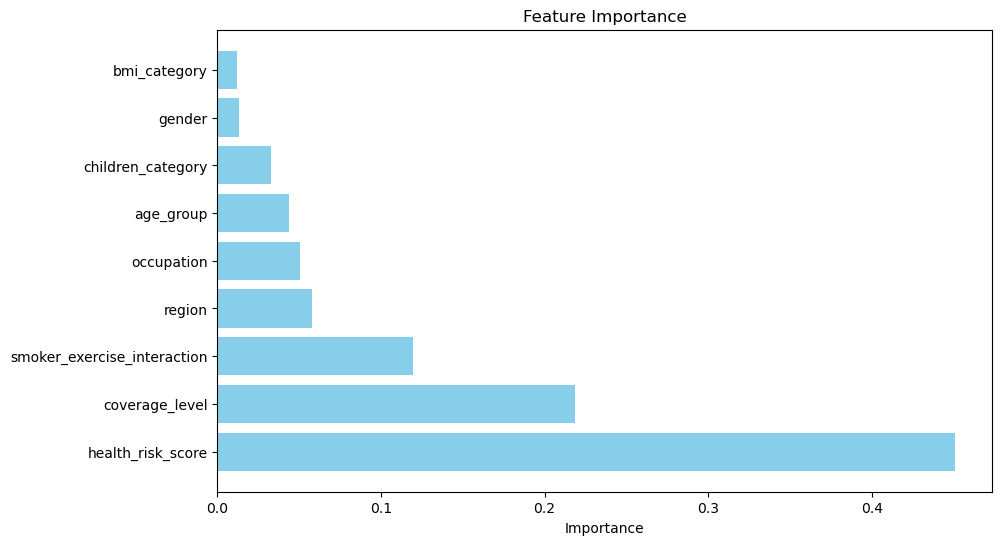

In [19]:
# Model Training using Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


# Feature Importance
importances = rf_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

c:\Users\gangu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


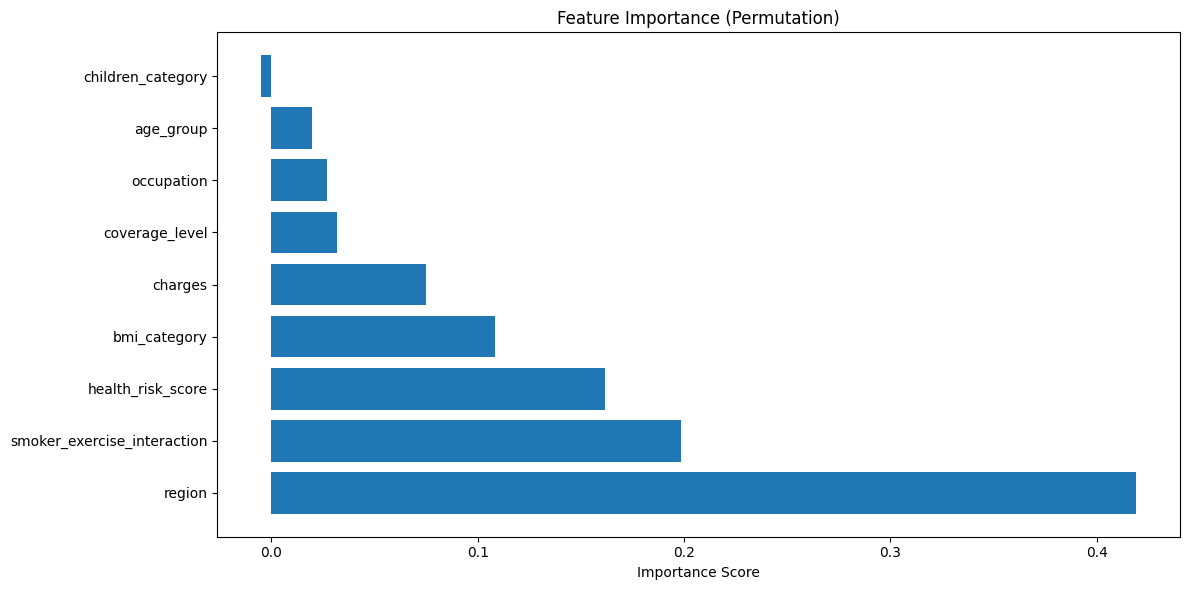


Feature Importance Rankings:
                       Feature  Importance
7                       region    0.419119
2  smoker_exercise_interaction    0.198428
1            health_risk_score    0.161606
0                 bmi_category    0.108307
5                      charges    0.074898
8               coverage_level    0.032019
6                   occupation    0.027070
3                    age_group    0.019666
4            children_category   -0.005039


In [73]:
from sklearn.inspection import permutation_importance
import numpy as np

X_test_df = pd.DataFrame(X_test, columns=required_features[:-1])  # Exclude 'charges' from features
y_test_series = pd.Series(y_test)

# Sample with index preservation
sample_indices = np.random.RandomState(42).choice(len(X_test), size=500, replace=False)
sample_X_test = X_test_df.iloc[sample_indices]
sample_y_test = y_test_series.iloc[sample_indices]

# Calculate permutation importance
perm_importance = permutation_importance(
    rf_model, 
    sample_X_test, 
    sample_y_test, 
    scoring='r2',
    n_repeats=10,
    n_jobs=-1,
    random_state=42
)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': required_features[:-1],  # Exclude 'charges' from features
    'Importance': perm_importance.importances_mean
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])  # Using horizontal bars for better readability
plt.title('Feature Importance (Permutation)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Print feature importance rankings
print("\nFeature Importance Rankings:")
print(importance_df)

# Summary

## Key Features & Impact:
1. **Health Risk Score** - Most influential, combining BMI and medical history.
2. **Smoker-Exercise Interaction** - Significant, highlighting lifestyle choices.
3. **Region** - High impact, likely due to cost variations.
4. **Coverage Level & Occupation** - Moderate influence on pricing.
5. **Age Group & Children Category** - Minimal predictive power.

## Feature Importance Analysis:
- **Permutation Importance:** Region had the highest impact, followed by smoker-exercise interaction and health risk score.
- **Random Forest Importance:** Health risk score was most significant, with coverage level and smoker-exercise interaction also notable.

## Key Insights:
- **Lifestyle and health metrics drive charges** more than demographics.
- **Potential redundancy** in health risk score and BMI category.
- **Region's strong influence** suggests pricing bias.
- **Children and BMI categories are less relevant.**

## Conclusion:
Health-related and lifestyle factors dominate insurance charge predictions. Reducing redundancy and validating regional influence can enhance model performance.